In [35]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [25]:
DATASET_NAME = 'natops'

In [26]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False)

In [27]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
], verbose=True)

In [28]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=   0.3s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s


/usr3/graduate/baksar/.local/lib/python3.6/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.2s


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier(class_weight='balanced'))],
         verbose=True)

In [29]:
preds = pipeline.predict(test_timeseries)

In [30]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.7714616550045748
1 0.983050847457627
2 0.711864406779661
3 0.7419354838709677
4 0.6363636363636365
5 0.5555555555555556
6 1.0


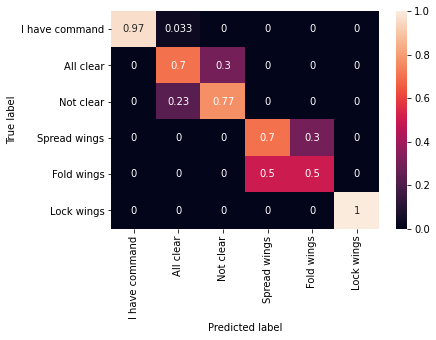

In [31]:
label_list = pipeline.steps[4][1].classes_
cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
for i in range(len(cf)):
    cf[i] = [x / cf[i].sum() for x in cf[i]]    
label_dict = {'1': 'I have command',  '2': 'All clear',  '3': 'Not clear', '4': 'Spread wings', '5': 'Fold wings', '6': 'Lock wings'}
text_labels = [label_dict[i] for i in label_list]
sns.heatmap(cf, annot=True, xticklabels=text_labels, yticklabels=text_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
comte = explainers.OptimizedSearch(pipeline, timeseries, labels, silent=False, threads=4,num_distractors=2)

In [33]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 2 #UPDATE HERE FOR OTHER CLASSES
pred_select = 3 #UPDATE HERE FOR OTHER CLASSES

indices_test = []
for idx, (true, pred) in enumerate(zip(test_labels['label'].values, preds)):
    if true ==  str(true_select) and pred == str(pred_select):
        indices_test.append(idx)

2021-04-30 11:42:54,106 INFO    Working on turning label from 3 to 4
2021-04-30 11:42:54,660 INFO    Finished constructing per class kdtree
2021-04-30 11:42:54,664 INFO    Returning distractors [109, 42]
2021-04-30 11:42:54,664 INFO    Trying distractor 1 / 2
2021-04-30 11:45:11,487 INFO    Current probas: [[0.12 0.22 0.3  0.11 0.06 0.19]]
2021-04-30 11:45:11,489 INFO    Trying distractor 2 / 2
2021-04-30 11:47:27,926 INFO    Current probas: [[0.1  0.18 0.32 0.1  0.04 0.26]]
2021-04-30 11:47:27,929 INFO    Used greedy search for 6
2021-04-30 11:47:27,953 INFO    Working on turning label from 2 to 3
2021-04-30 11:47:27,958 INFO    Returning distractors [109, 42]
2021-04-30 11:47:27,959 INFO    Trying distractor 1 / 2
2021-04-30 11:47:27,982 INFO    Current probas: [[0.17 0.31 0.49 0.   0.   0.03]]
2021-04-30 11:47:28,257 INFO    Best column: Hand tip left, X, best case: 0.05
2021-04-30 11:47:28,313 INFO    Current probas: [[0.13 0.25 0.38 0.05 0.03 0.16]]
2021-04-30 11:47:28,587 INFO   

###########
['Hand tip left, X', 'Wrist left, X', 'Hand tip left, Y', 'Elbow left, X', 'Thumb left, Y']
###########


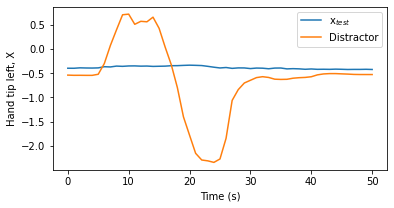

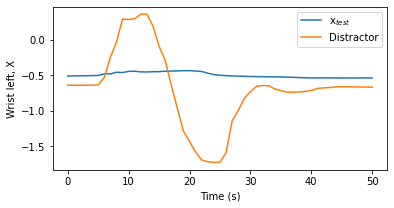

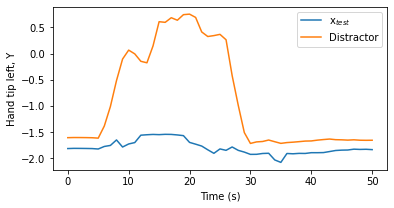

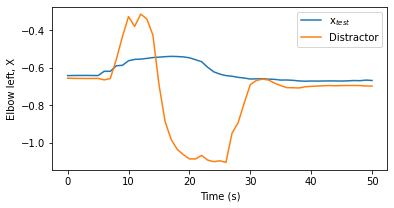

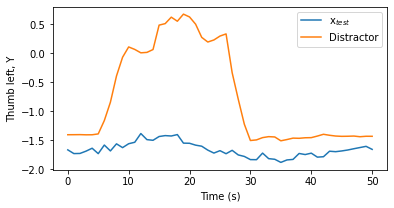

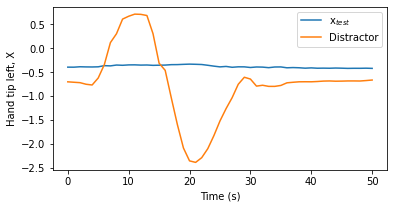

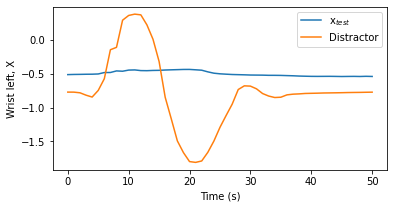

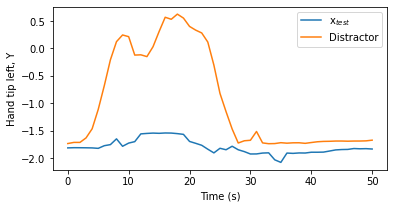

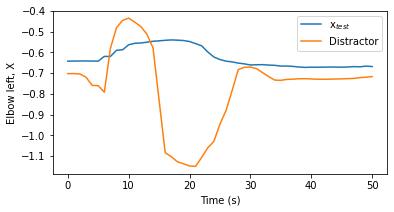

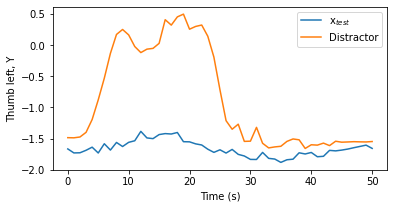

In [34]:
for ind in indices_test:
    x_test = test_timeseries.loc[[ind], :, :]
    explanation = comte.explain(x_test,to_maximize=pred_select,savefig=False) 
    print('###########')
    print(explanation)
    print('###########')
    break